In [96]:
# Alle Variablen löschen ohne zu fragen.
# Hierdurch werden Seiteneffekte vermieden.
%reset -f

In [97]:
# Voraussetzung: Mindestens tensorflow-Version 2
# mit integriertem Keras 

import tensorflow
print('Keras      :', tensorflow.keras.__version__)
print('Tensorflow :', tensorflow.__version__)

Keras      : 2.2.4-tf
Tensorflow : 2.1.0






# Multiclass-Klassifikation 
## Zweck
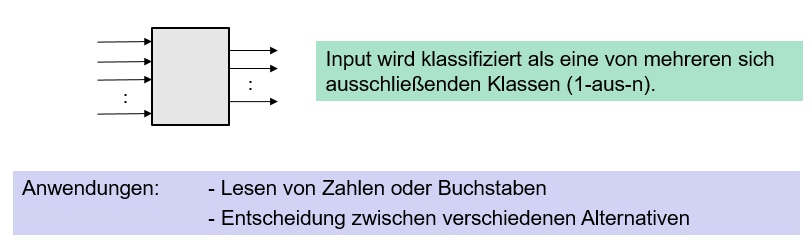

## Beispiel: Lesen handgeschriebener Zahlen 
### Idee
Im folgenden Beispiel sollen handgeschriebene Zahlen (Bildgröße 28x28) klassifiziert werden.
### Daten
Die Daten für das Training und die Validation des Klassifikators, stammen aus dem MNIST-Dataset.  
Die Daten sind wie folgt aufgeteilt: 60.000 Trainingsdaten und 10.000 Testdaten.  
Der MNIST-Datensatz ist im Keras-Paket enthalten.

---



# Es geht los ......
### Laden der benötigten Python-Bibliotheken
<ul>
<li><strong>numpy</strong>: Wissenschaftliches Rechnen mit Python
<li><strong>keras</strong>: Zusatz zu Tensorflow. Die Erstellung und das Training Neuronaler Netze wird dadurch erheblich vereinfacht.
<lu>

In [98]:
# Biliothek: Drucken von Grafiken, Bildern, etc. .....
from matplotlib            import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Biliothek: Drucken von Grafiken, Bildern, etc. .....
from matplotlib            import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Bibliothek: Rechnen mit Matrizen, Vektoren, etc. ......
import numpy as np

from tensorflow.keras.models          import Sequential
from tensorflow.keras.datasets        import mnist
from tensorflow.keras.layers          import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers          import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils           import model_to_dot, plot_model, to_categorical
from tensorflow.keras.optimizers      import RMSprop, SGD


### Reproduzierbare Versuche
Zufallszahlengenerator (z.B. bei der Initialisierung von NN) immer gleich starten (mit seed()).<br />
Versuche werden dadurch wiederholbar und vergleichbar.

In [99]:
np.random.seed(13)

### MNIST-Datensatz für Training und Test laden

In [100]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()   # MNIST-Datensatz laden

NumClasses         = 10                    # Anzahl der Klassen (MNIST)
ImgRows, ImgCols   = 28, 28                # Format des Input-Fensters (MNIST)
InputSize          = ImgRows * ImgCols     # Größe des Input-Fensters (MNIST)

In [101]:
print('X_train_ori :', X_train_ori.shape)
print('X_test_ori  :', X_test_ori.shape)

X_train_ori : (60000, 28, 28)
X_test_ori  : (10000, 28, 28)


### Hilfsfunktionen

In [102]:
#  Funktionsdeklaration : Bilder in einem Raster Drucken
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    plt.gray()

# ============================================================

# Versuch 1: Multilayer-Perzeptron mit einem hidden Layer

### Formatierung der Trainings- und Testdaten für das Multilayer-Perzeptron
Multilayer-Perzeptron bekommt kein 28x28-Bild, sondern einfach nur 784 Inputwerte (= InputSize).

In [103]:
X_train = X_train_ori.reshape(60000, InputSize)
X_test  = X_test_ori.reshape( 10000, InputSize)

In [104]:
print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


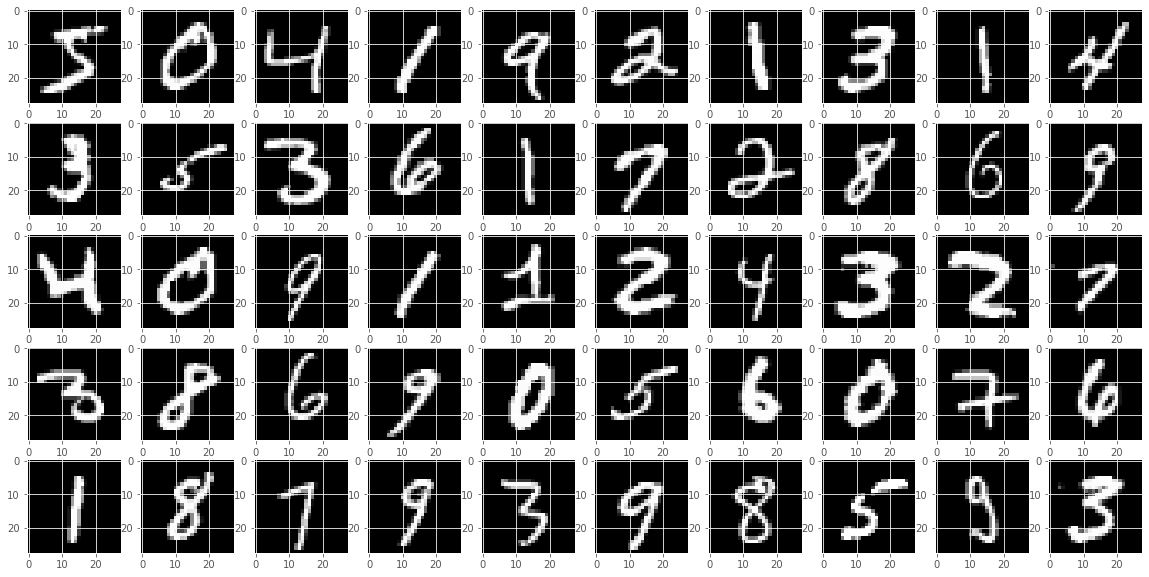

In [105]:
# Eine Auswahl von handgeschriebenen Zeichen in einem Bildraster anzeigen
cols                = 10
rows                = 5
plt.figure(figsize  = (20,10))

for i in range(rows):
    for k in range(cols):
        draw_digit(X_train[i*10+k].reshape(28,28), rows, cols, i*10+k+1)

plt.show()

### Grauwerte der Bilder für das NN aufbereiten

In [106]:
# Bildpunkttyp (Grauwerte = 0 ...255) auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf den Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


### Ergebnisse der Trainings- und Testdaten aufbereiten

Die Ergebnisse (Klassen der Bilder) liegen im Datensatz als Integerzahl vor (z.B. 7) wenn eine 7 abgebildet ist.<br />
Benötigt werden aber die Outputs des NN, also z.B. [0 0 0 0 0 0 0 1 0 0] für die abgebildete 7 (= One-hot-Encoding). 

Zu diesem Zweck müssen die Outputklassen konvertiert werden.

In [107]:
print(y_train_ori.shape)
print(y_train_ori[:5])

(60000,)
[5 0 4 1 9]


In [108]:
# Zahlenwert der Outputklasse konvertieren in 10-dim. Outputvektor transformieren (to_categorical-Methode)
Y_train = to_categorical(y_train_ori, 10)
Y_test  = to_categorical(y_test_ori,  10)

print(Y_train.shape)
print()
print(y_train_ori[:5])
print()
print(Y_train[:5])

(60000, 10)

[5 0 4 1 9]

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Beschreibung des gewünschten Neuronalen Netzes
Mit model.add() wird Schicht für Schicht des NN beschrieben.
<ul>
<li><strong>Dense</strong>: Einfacher Fully-connected-Layer.
<li><strong>sigmoid</strong>: Logistische Aktivierrungsfunktion (Alternativen: tanh, relu, selu, ....).
<li><strong>glorot_uniform</strong>: Methode zur zufälligen Gewichtsinitialisierung.
</ul>

Der letzte Layer ist als *softmax-Layer* ausgelegt. Die Summe der Ausgabewerte ist somit 1.

In [109]:
# ----------------------------------------------------
# Netz 1: Feed-forward-Netzwerk mit mehreren Layern
# ----------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 200,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("relu"))

# weitere Möglichkeiten sind z.B. 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units = 100,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("relu"))

model.add(Dropout(0.2))

# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(BatchNormalization())
model.add(Activation('softmax'))

# ------------------------------------------------------------------------------------------

In [110]:
# Übersicht über das NN und die Parameter
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 200)               157000    
_________________________________________________________________
activation_72 (Activation)   (None, 200)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 200)               800       
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_73 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)             

### Konfiguration des Lernprozesses
Gute Erklärungen zu den Parametern sind hier zu finden:  ([link](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop))

In [111]:
model.compile(loss      = 'categorical_crossentropy',
              optimizer = 'adam',     # adam, rmsprop
              metrics   = ['accuracy'])

### Training des NN

In [112]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  15,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 6s 94us/sample - loss: 0.4991 - accuracy: 0.8906 - val_loss: 0.1735 - val_accuracy: 0.9599
Epoch 2/15
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2562 - accuracy: 0.9386 - val_loss: 0.1232 - val_accuracy: 0.9638
Epoch 3/15
60000/60000 [==============================] - 5s 90us/sample - loss: 0.1928 - accuracy: 0.9519 - val_loss: 0.0911 - val_accuracy: 0.9740
Epoch 4/15
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1536 - accuracy: 0.9606 - val_loss: 0.0911 - val_accuracy: 0.9756
Epoch 5/15
60000/60000 [==============================] - 5s 88us/sample - loss: 0.1330 - accuracy: 0.9639 - val_loss: 0.0687 - val_accuracy: 0.9789
Epoch 6/15
60000/60000 [==============================] - 5s 84us/sample - loss: 0.1165 - accuracy: 0.9692 - val_loss: 0.0705 - val_accuracy: 0.9789
Epoch 7/15
60000/60000 [==============================] 

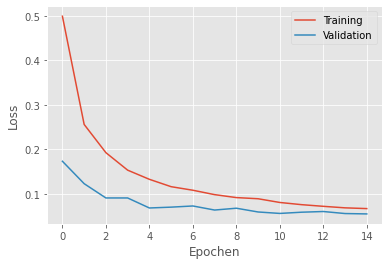

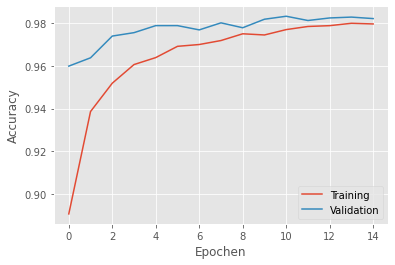

In [113]:
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

Modifizieren Sie das NN und das Training z.B. durch
* Layerzahl, 
* Neuronen pro Layer, 
* relu, selu, tanh, sigmoid
* adam, rmsprop
* Anzahl der Trainingsepochen, 
* Batchsize, usw. ... 

mit dem Ziel, eine Validation-Accuracy von mindestens 98.2% ** oder besser zu erreichen.  

### Dokumentieren
* die Parameter des NN und des Trainings 
* Val.-Accuracy 
* graph. Traingsverläufe 

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [114]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero

<Figure size 432x288 with 0 Axes>

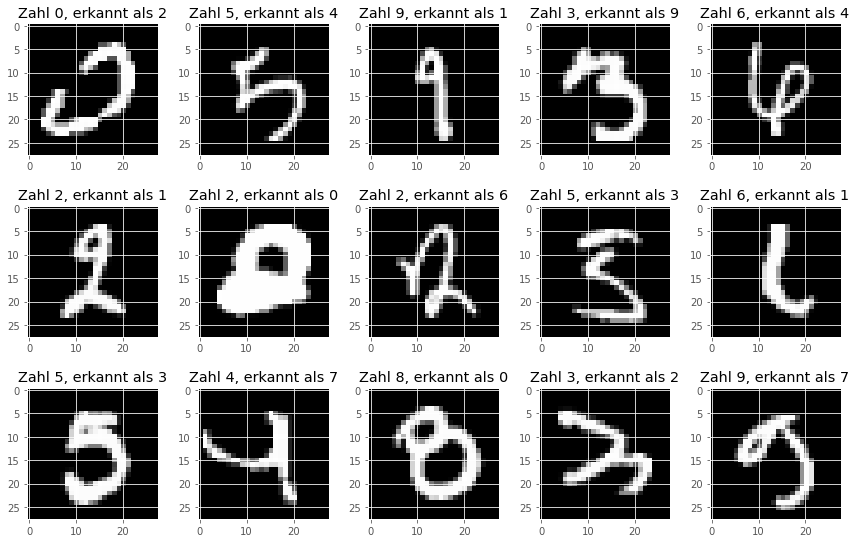

In [115]:
start                = 60    # Startindex

plt.figure(2)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [116]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 972    1    1    0    1    1    1    0    2    1]
 [   0 1122    4    0    0    0    2    1    6    0]
 [   3    1 1014    2    0    0    2    8    2    0]
 [   0    0    3  991    0    1    0    6    4    5]
 [   1    0    1    0  956    0    4    2    1   17]
 [   2    1    0   12    2  868    3    1    2    1]
 [   5    2    1    1    3    4  941    0    1    0]
 [   1    3    8    1    0    0    0 1007    2    6]
 [   5    0    2    3    2    1    0    3  957    1]
 [   0    2    0    4    3    2    0    3    1  994]]


# ==============================================================

# Versuch 2: Kleines Faltungsnetzwerk (CNN)

### Für Faltungsnetzwerke müssen die Bilddaten etwas anders aufbereitet werden (2-dimensional).

In [123]:
# Die Bilder sollen auf das Format 28x28x1 gebracht werden (28x28-Grauwertbild)

shape_ord = (ImgRows, ImgRows, 1)
    
print(shape_ord)
print(type(shape_ord))

(28, 28, 1)
<class 'tuple'>


In [124]:
# ....
X_train = X_train_ori.reshape((X_train.shape[0],) + shape_ord)
X_test  = X_test_ori.reshape((X_test.shape[0],)   + shape_ord)

# Bildpunkttyp auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 28, 28, 1)
X_test  : (10000, 28, 28, 1)


In [125]:
# ------------------------------------------------------------
# Netz 2: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 kernel_size=(5, 5),   # alt kernel_size=(5, 5)
                 padding='valid', 
                 input_shape = shape_ord))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))


# weitere Möglichkeiten sind z.B. 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=256))
model.add(Activation('relu'))

#model.add(Dropout(0.4))

model.add(Dense(units=10))
model.add(Activation('softmax'))

# ??? Frage

Berechnen Sie händisch die Anzahl der zu trainierenden Parameter für das angegebene Faltungsnetzwerk 
und vergleichen Sie Ihr Ergebnis mit dem model.summary().

In [126]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_80 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_46 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_81 (Activation)   (None, 10, 10, 64)      

In [127]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 128, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2044 - accuracy: 0.9365 - val_loss: 0.1997 - val_accuracy: 0.9357
Epoch 2/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0762 - accuracy: 0.9764 - val_loss: 0.0358 - val_accuracy: 0.9888
Epoch 3/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0596 - accuracy: 0.9814 - val_loss: 0.0405 - val_accuracy: 0.9877
Epoch 4/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0492 - accuracy: 0.9844 - val_loss: 0.0383 - val_accuracy: 0.9888
Epoch 5/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0452 - accuracy: 0.9858 - val_loss: 0.0316 - val_accuracy: 0.9916
Epoch 6/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0411 - accuracy: 0.9873 - val_loss: 0.0333 - val_accuracy: 0.9903
Epoch 7/10
60000/60000 [==============================] 

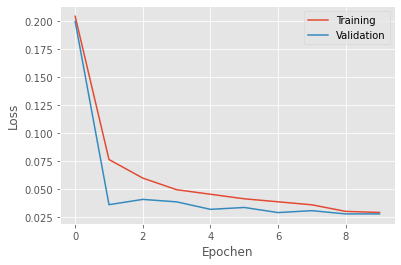

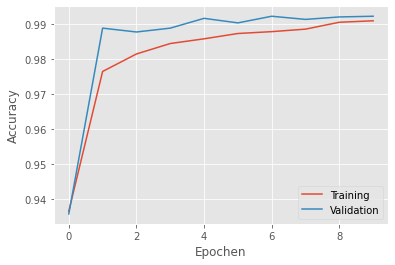

In [129]:
plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

Modifizieren Sie das NN und das Training z.B. durch
* Layerzahl,
* Kernel-Size,
* Neuronen (=filters) pro Layer, 
* relu, selu, tanh, sigmoid
* adam, rmsprop
* Anzahl der Trainingsepochen, 
* Batchsize, usw. ... 

mit dem Ziel, eine Validation-Accuracy von mind. 99.2% oder besser zu erreichen.  

### Dokumentieren
* die Parameter des NN und des Trainings 
* Val.-Accuracy 
* graph. Traingsverläufe 

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [130]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero ()

In [131]:
predicted_classes

array([7, 2, 1, ..., 4, 5, 6])

In [132]:
# predicted_classes[40:45]
# y_test_ori[40:45]
# np.nonzero(predicted_classes == y_test_ori)[0].shape
np.nonzero(predicted_classes != y_test_ori)[0].size

78

<Figure size 432x288 with 0 Axes>

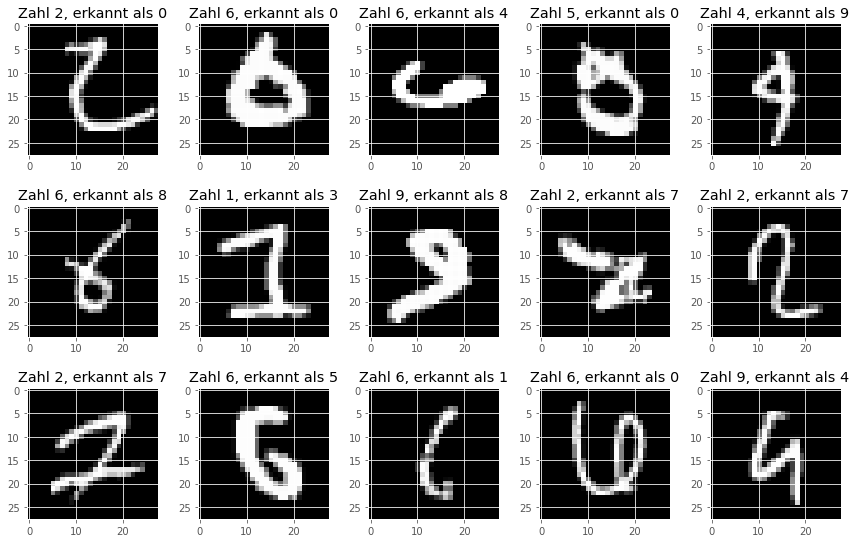

In [133]:
start                = 40    # Startindex

plt.figure(8)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [134]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [   2    0 1019    0    1    0    1    9    0    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    1  971    0    0    0    0   10]
 [   2    1    0    4    0  883    1    1    0    0]
 [   5    5    0    0    1    5  941    0    1    0]
 [   0    2    2    1    0    0    0 1021    0    2]
 [   0    1    1    1    0    2    0    0  968    1]
 [   1    0    0    0    3    0    0    1    1 1003]]
